In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

# Data Wrangling

Before we start our analysis, we check the quality of the data, simplify the
structure where possible, and derive new measurements that might help us in our
analysis. We cover these types of operations in {numref}`Chapter %s <ch:wrangling>`, so don't worry about the details of the code for now. Instead,
focus on the differences between the data tables as we clean the data. We start by loading the data into Python.

In [2]:
bus = (pd.read_csv('data/seattle_bus_times.csv')
       .dropna(axis=0, how='any'))

The first few rows in the data table are shown here:

In [3]:
bus.head(3)

,OPD_DATE,VEHICLE_ID,RTE,DIR,...,STOP_ID,STOP_NAME,SCH_STOP_TM,ACT_STOP_TM
0,2016-03-26,6201,673,S,...,431,3RD AVE & PIKE ST (431),01:11:57,01:13:19
1,2016-03-26,6201,673,S,...,431,3RD AVE & PIKE ST (431),23:19:57,23:16:13
2,2016-03-26,6201,673,S,...,431,3RD AVE & PIKE ST (431),21:19:57,21:18:46


(The raw data are available as comma-separated values in a file, which we have loaded into this table; see {numref}`Chapter %s <ch:files>` for details on this process.)

It looks like some of the columns in the table might be redundant, like the columns labeled `STOP_ID` and `STOP_NAME`. We can find the number of unique values and their counts to confirm this:

In [9]:
bus[['STOP_ID','STOP_NAME']].value_counts()

STOP_ID  STOP_NAME              
578      3RD AVE & PIKE ST (578)    19599
431      3RD AVE & PIKE ST (431)    19318
dtype: int64

There are two `3RD AVE & PIKE ST` names for the stop. We wonder whether they are related to the direction of the bus, which we can check against the possible combinations of direction, stop ID and stop name: 

In [11]:
bus[['DIR','STOP_ID','STOP_NAME']].value_counts()

DIR  STOP_ID  STOP_NAME              
N    578      3RD AVE & PIKE ST (578)    19599
S    431      3RD AVE & PIKE ST (431)    19318
dtype: int64

Indeed, the northern direction corresponds to stop ID 578 and the southern direction corresponds to stop ID 431. Since we are looking at only one stop in our analysis, we don't really need anything more than the direction. 

We can also check the number of unique route names:

In [12]:
bus['RTE'].value_counts()

673    13228
674    13179
675    12510
Name: RTE, dtype: int64

These routes are numbered and don't match the names C, D, and E from the original description of the problem.  This issue involves another aspect of data wrangling: we need to dig up information that connects the route letters and numbers. We can get this info from the Seattle transit site. Yet another part of wrangling is to translate data values into ones that are easier to understand, so we replace the route numbers with their letters:

In [4]:
def clean_stops(bus):
    return bus.assign(
        route=bus["RTE"].replace({673: "C", 674: "D", 675: "E"}),
        direction=bus["DIR"].replace({"N": "northbound", "S": "southbound"}),
    )

We can also create new columns in the table that help us in our investigations. For example, we can use the scheduled and actual arrival times to calculate how late a bus is. To do this requires some work with date and time formats, which is covered in {numref}`Chapter %s <ch:wrangling>`.  

In [5]:
def compute_mins_late(bus):
    bus = bus.assign(
        scheduled=pd.to_datetime(bus["OPD_DATE"] + " " + bus["SCH_STOP_TM"]),
        actual=pd.to_datetime(bus["OPD_DATE"] + " " + bus["ACT_STOP_TM"]),
    )
    # if scheduled & actual span midnight, then the actual day needs to be
    # adjusted
    minute = pd.Timedelta("1 minute")
    hour = pd.Timedelta("1 hour")
    diff_hrs = (bus["actual"] - bus["scheduled"]) / hour
    bus.loc[diff_hrs > 20, "actual"] -= 24 * hour
    bus.loc[diff_hrs < -20, "actual"] += 24 * hour
    return bus.assign(minutes_late=(bus["actual"] - bus["scheduled"]) / minute)

bus = (
    pd.read_csv("data/seattle_bus_times.csv")
    .dropna(axis=0, how="any")
    .pipe(clean_stops)
    .pipe(compute_mins_late)
)
bus.head(3)

,OPD_DATE,VEHICLE_ID,RTE,DIR,...,direction,scheduled,actual,minutes_late
0,2016-03-26,6201,673,S,...,southbound,2016-03-26 01:11:57,2016-03-26 01:13:19,1.37
1,2016-03-26,6201,673,S,...,southbound,2016-03-26 23:19:57,2016-03-26 23:16:13,-3.73
2,2016-03-26,6201,673,S,...,southbound,2016-03-26 21:19:57,2016-03-26 21:18:46,-1.18


Let's examine the values of this new quantity to make sure that our calculations are correct: 

In [6]:
print(f" smallest amount late: {np.min(bus['minutes_late']):.2f} minutes\n",
      f"greatest amount late:  {np.max(bus['minutes_late']):.2f} minutes\n",
      f"median amount late:    {np.median(bus['minutes_late']):.2f} minutes\n")

 smallest amount late: -12.87 minutes
 greatest amount late:  150.28 minutes
 median amount late:    0.52 minutes



It's a bit surprising that there are negative values for how late a bus is, but this just means the bus arrived earlier than scheduled. While the median lateness is only about half a minute, some of the buses are 2.5 hours late! Let's take a look at the histogram of how many minutes late the buses are:

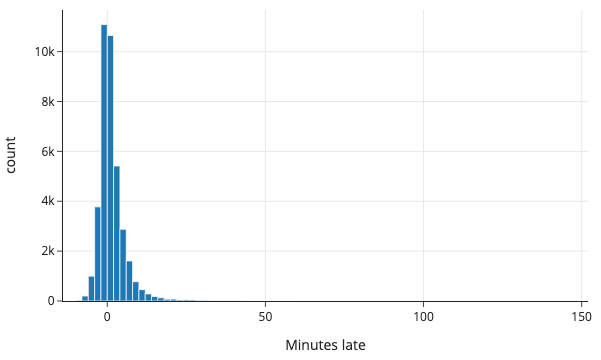

In [7]:
px.histogram(bus, x="minutes_late", nbins=120, width=450, height=300, 
             labels={'minutes_late':'Minutes late'})

We saw a similarly shaped histogram in {numref}`Chapter %s <ch:modeling>`. The distribution of how late the buses are is highly skewed to the right, but many arrive close to on time. 

Finally, we conclude our wrangling by creating a simplified version of the data table. Since we only need to  keep track of the route, direction, scheduled and actual arrival time, and how late the bus is, we create a smaller table and give the columns names that are a bit easier to read:

In [31]:
bus = bus[["route", "direction", "scheduled", "actual", "minutes_late"]]
bus.head()

,route,direction,scheduled,actual,minutes_late
0,C,southbound,2016-03-26 01:11:57,2016-03-26 01:13:19,1.37
1,C,southbound,2016-03-26 23:19:57,2016-03-26 23:16:13,-3.73
2,C,southbound,2016-03-26 21:19:57,2016-03-26 21:18:46,-1.18
3,C,southbound,2016-03-26 19:04:57,2016-03-26 19:01:49,-3.13
4,C,southbound,2016-03-26 16:42:57,2016-03-26 16:42:39,-0.30


These table manipulations are covered in {numref}`Chapter %s <ch:pandas>`. 

Before we begin to model bus lateness, we want to explore and learn more about these data. We do that next.